In [1]:
import os
import re

from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from time import sleep

from bot.core.exchange.http_api import ExchangeManager, BybitRestAPI
from bot.utils.files import load_tokens_from_file
from bot.utils.coinmarketcap import get_top_tokens
from bot.core.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name

db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

import pandas as pd
# pd.options.display.float_format = '{:.2f}'.format

import polars as pl
import polars_ols as pls

import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

In [2]:
def sort_pairs(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns([
        pl.when(pl.col("coin1") <= pl.col("coin2")).then(pl.col("coin1")).otherwise(pl.col("coin2")).alias("pair_min"),
        pl.when(pl.col("coin1") <= pl.col("coin2")).then(pl.col("coin2")).otherwise(pl.col("coin1")).alias("pair_max"),
    ]).drop('coin1', 'coin2').rename({'pair_min': 'coin1', 'pair_max': 'coin2'}).select('coin1', 'coin2', pl.exclude('coin1', 'coin2'))

In [3]:
# get_top_tokens(limit=1000, output_file='./bot/config/top_1000_tokens.txt')

#### Скачиваем данные с Bybit

In [4]:
async def get_data(symbol, interval, n_iters):
    df = await exc_manager.get_candles(symbol=symbol, interval=interval, n_iters=n_iters)
    df = df['bybit_linear'].sort_index()
    df['Returns'] = df['Close'].pct_change()
    df['Log_price'] = np.log(df['Close'] + 1)
    df['Log_returns'] = np.log(df['Returns'] + 1)
    return df.dropna()

In [5]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))

In [6]:
res = await get_data(symbol='ADA_USDT', interval='1h', n_iters=1)
res.shape

(999, 11)

In [7]:
top_1000_tokens = load_tokens_from_file("./data/top_1000_tokens.txt")
tokens_to_del = ['USDT', 'USDC', 'LEO', 'USDe']
token_list = [x + '_USDT' for x in top_1000_tokens if x not in tokens_to_del]

In [8]:
prices = await exc_manager.get_prices()
prices = prices['bybit_linear']
len(prices)

557

In [9]:
with open('./bot/config/tokens.txt', 'r') as file:
    current_tokens = [line.strip() for line in file.readlines()]
len(current_tokens)

66

In [10]:
all_ = db_manager.get_orderbooks()
all_tokens = all_['token'].unique().to_list()

In [11]:
token_list = []

for token in sorted(all_tokens):
    first_date = db_manager.get_oldest_date_in_orderbook(token)
    
    if first_date < datetime(2025, 11, 4, 0, tzinfo=ZoneInfo("Europe/Moscow")):
        token_list.append(token)
len(token_list)

40

In [12]:
# Настройки параметров
interval = '1d'
n_iters = 1
start_date = datetime(2025, 5, 1, tzinfo=ZoneInfo("Europe/Moscow"))
end_date = datetime(2025, 11, 15, tzinfo=ZoneInfo("Europe/Moscow"))
min_volume = 1_000_000
days_ago = 30 # За сколько последних дней смотреть волатильность
max_volatility = 55
max_price = 20

In [13]:
main_df = pd.DataFrame()

token_dict = {'PEPE_USDT': '1000PEPE_USDT', 'SHIB_USDT': 'SHIB1000_USDT', 'FLOKI_USDT': '1000FLOKI_USDT',
             'BONK_USDT': '1000BONK_USDT', 'BTT_USDT': '1000BTT_USDT', 'XEC_USDT': '1000XEC_USDT',
             'LUNC_USDT': '1000LUNC_USDT', 'SATS_USDT': '10000SATS_USDT', 'TURBO_USDT': '1000TURBO_USDT',
             'CAT_USDT': '1000CAT_USDT'}
bad_tokens = []
good_tokens = []

for token in tqdm(token_list):
    df = await get_data(symbol=token, interval=interval, n_iters=n_iters)
    df = df.reset_index()

    if df.empty:
        continue
    
    # first_date = df['Date'].head(1).item().floor('D')
    # last_date = df['Date'].tail(1).item().floor('D')
    
    # if first_date > pd.Timestamp('2025-06-10', tz='Europe/Moscow'):
    #     continue
    # if last_date < pd.Timestamp('2025-11-10', tz='Europe/Moscow'):
    #     continue

    row = df[df['Date'].dt.date == (end_date - timedelta(days=2)).date()]
    vol24 = row['Turnover'].item() # Берём предпоследнюю запись, потому что последний день будет половинчатым
    if vol24 < min_volume:
        if token in current_tokens:
            print(f'{token} недостаточно торгового объёма ({int(vol24):_})')
            bad_tokens.append(token)
        continue
    
    df = df[(df['Date'] > start_date) & (df['Date'] < end_date)]
    df = df.set_index('Date')
    daily_df = df[-days_ago:]
    daily_df['Max_range'] = daily_df['High'] - daily_df['Low']
    daily_df['Max_range_perc'] = (daily_df['High'] - daily_df['Low']) / daily_df['Low'] * 100

    if daily_df['Max_range_perc'].max() > max_volatility:
        if token in current_tokens:
            print(f'{token} высокая волатильность: {daily_df['Max_range_perc'].max():.1f}%')
            bad_tokens.append(token)
        continue

    if daily_df['Close'][-1] > max_price:
        continue

    main_df[f'{token[:-5]}_price'] = df['Close']
    main_df[f'{token[:-5]}_log_returns'] = df['Log_returns']
    main_df[f'{token[:-5]}_log_price'] = df['Log_price']
    good_tokens.append(token)

    sleep(1)

  0%|          | 0/40 [00:00<?, ?it/s]

In [14]:
main_df.shape

(198, 120)

In [15]:
len(current_tokens), len(bad_tokens), len(good_tokens)

(66, 0, 40)

In [ ]:
[current_tokens.remove(token) for token in bad_tokens]
len(current_tokens)

In [ ]:
len(good_tokens), len(set(good_tokens))

#### Distance approach

In [16]:
from bot.utils.data import make_price_df_from_orderbooks_bulk, normalize
import itertools
import math

In [17]:
exc_manager = ExchangeManager()
exc_manager.add_market("bybit_linear", BybitRestAPI('linear'))
coin_information = exc_manager.get_instrument_data()

In [18]:
# Создадим список из датафреймов для удобства пакетной обработки, а также получим кол-во знаков после запятой для округления
max_days = 180 # За сколько дней считать расстояние
tokens = [x[:-5] for x in set(token_list)]
dfs = []
# token_dp = {}
token_std = {}
token_dist = {}

for token in tokens:
    try:
        df_token = main_df[[f'{token}_price']].rename(columns={f'{token}_price': 'price'})
        df_token['token'] = token
        df_token = pl.from_pandas(df_token, include_index=True).rename({'Date': 'time'}).tail(max_days)
    except KeyError:
        print(token)
        continue
    
    try:
        dp = coin_information['bybit_linear'][token + '_USDT']['qty_step']
    except IndexError:
        dp = 0

    # token_dp[token] = dp
    token_std[token] = df_token['price'].std()
    token_dist[token] = df_token['price'].max() - df_token['price'].min()
    dfs.append(df_token)

In [19]:
price_df = make_price_df_from_orderbooks_bulk(dfs=dfs, tokens=tokens, trunc='5m')
curr_prices = price_df.drop('time').tail(1).transpose(include_header=True, header_name='coin', column_names=['price'])
price_df.tail(1)

time,FLOW,ONDO,XRP,GMT,MOVE,SEI,VET,MANTA,STRK,NEAR,GALA,JASMY,IOTA,STX,IMX,DYDX,ARKM,ARB,1INCH,OP,KAS,BLUR,APT,MORPHO,POL,SUI,ROSE,SUSHI,CELO,DOT,ORDI,RENDER,SAND,TIA,CRV,GRT,CHZ,KSM,LDO,MANA
"datetime[ns, Europe/Moscow]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-11-14 03:00:00 MSK,0.2569,0.5747,2.2426,0.02153,0.05232,0.1596,0.01544,0.11827,0.17,2.352,0.008951,0.008573,0.1304,0.3596,0.3758,0.2916,0.2907,0.2374,0.1809,0.3784,0.04446,0.0417,2.918,1.9971,0.1515,1.7391,0.0184,0.4565,0.2024,2.8112,4.479,2.094,0.1797,0.8515,0.4293,0.05643,0.0309,9.976,0.751,0.2033


In [20]:
price_df.shape, price_df.drop_nans().shape

((180, 41), (180, 41))

In [21]:
normed_df = normalize(df=price_df, method='minimax', shift_to_zero=False)

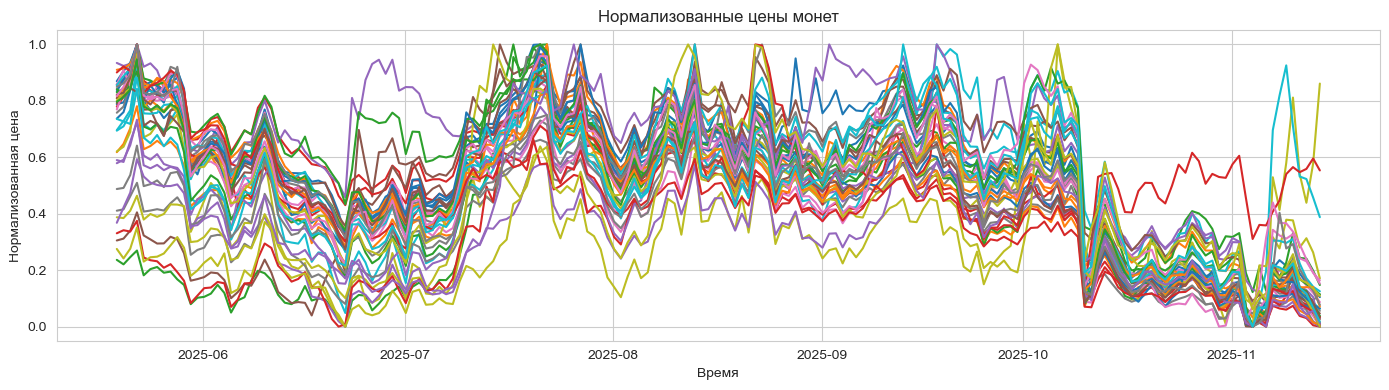

In [22]:
# Нарисуем график с нормализованными ценами
price_cols = [c for c in normed_df.columns if c != 'time']

plt.figure(figsize=(14, 4))
for col in price_cols:
    plt.plot(normed_df['time'].to_list(), normed_df[col].to_list(), label=col)

plt.xlabel("Время")
plt.ylabel("Нормализованная цена")
plt.title("Нормализованные цены монет")
plt.grid(True)
plt.tight_layout()

In [23]:
# Посчитаем евклидово расстояние между парами криптовалют
results = []

# Перебираем все уникальные пары колонок
for col1, col2 in itertools.combinations(price_cols, 2):
    diff_sq = (normed_df[col1] - normed_df[col2]) ** 2
    distance = math.sqrt(diff_sq.sum())
    std = np.std((normed_df[col1] - normed_df[col2]).to_numpy())
    results.append((col1, col2, distance, std))

In [24]:
std_df = pl.DataFrame({"token": list(token_std.keys()), "std_value": list(token_std.values())})
max_dist_df = pl.DataFrame({"token": list(token_dist.keys()), "max_dist": list(token_dist.values())})

# max_dist_df

In [25]:
dist_df = pl.DataFrame(results, schema=["coin1", "coin2", "dist", "std"], orient="row").sort('dist')
dist_df = dist_df.join(curr_prices, left_on='coin1', right_on='coin').rename({'price': 'price1'})
dist_df = dist_df.join(curr_prices, left_on='coin2', right_on='coin').rename({'price': 'price2'})
dist_df = dist_df.filter(
    (pl.col('price1') / pl.col('price2') < 5) & (pl.col('price1') / pl.col('price2') > 0.2)
)

In [26]:
dist_df = dist_df.join(std_df, left_on="coin1", right_on="token").rename({"std_value": "std_1"})
dist_df = dist_df.join(std_df, left_on="coin2", right_on="token").rename({"std_value": "std_2"})

dist_df = dist_df.join(max_dist_df, left_on="coin1", right_on="token").rename({"max_dist": "dist_1"})
dist_df = dist_df.join(max_dist_df, left_on="coin2", right_on="token").rename({"max_dist": "dist_2"})

In [27]:
dist_df

coin1,coin2,dist,std,price1,price2,std_1,std_2,dist_1,dist_2
str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""VET""","""GALA""",0.549994,0.034595,0.01544,0.008951,0.003475,0.00287,0.01667,0.01256
"""KAS""","""GRT""",0.684168,0.050949,0.04446,0.05643,0.016267,0.014785,0.07339,0.06767
"""BLUR""","""GRT""",0.738202,0.051791,0.0417,0.05643,0.016754,0.014785,0.07046,0.06767
"""VET""","""GRT""",0.775648,0.047342,0.01544,0.05643,0.003475,0.014785,0.01667,0.06767
"""MANTA""","""STX""",0.796281,0.059084,0.11827,0.3596,0.050508,0.138479,0.2343,0.6469
…,…,…,…,…,…,…,…,…,…
"""MOVE""","""STRK""",4.374735,0.276407,0.05232,0.17,0.034662,0.015667,0.14038,0.0786
"""SEI""","""STRK""",4.424691,0.30125,0.1596,0.17,0.058718,0.015667,0.2126,0.0786
"""APT""","""LDO""",4.476158,0.274591,2.918,0.751,0.680025,0.217272,3.156,0.8869


In [28]:
# Добавить фичи: скорость возврата к среднему

#### Cointegration approach

In [29]:
ret_cols = [col for col in main_df.columns if '_log_price' in col]
corr_matrix = main_df[ret_cols].corr()

In [30]:
corr_matrix

,1INCH_log_price,APT_log_price,ARB_log_price,ARKM_log_price,BLUR_log_price,CELO_log_price,CHZ_log_price,CRV_log_price,DOT_log_price,DYDX_log_price,...,ROSE_log_price,SAND_log_price,SEI_log_price,STRK_log_price,STX_log_price,SUI_log_price,SUSHI_log_price,TIA_log_price,VET_log_price,XRP_log_price
1INCH_log_price,1.000000,0.518552,0.778565,0.602394,0.531445,0.575256,0.736915,0.827233,0.641303,0.725767,...,0.567368,0.727089,0.809151,0.450575,0.534923,0.763059,0.835793,0.421861,0.621941,0.828295
APT_log_price,0.518552,1.000000,0.497464,0.875776,0.893740,0.838323,0.854462,0.593631,0.889516,0.879346,...,0.865630,0.886713,0.486389,0.569473,0.915492,0.845823,0.711215,0.888237,0.902493,0.179158
ARB_log_price,0.778565,0.497464,1.000000,0.662357,0.485195,0.540987,0.729920,0.801192,0.666223,0.788269,...,0.533865,0.721955,0.812207,0.363903,0.465970,0.774921,0.857492,0.410467,0.639998,0.784383
ARKM_log_price,0.602394,0.875776,0.662357,1.000000,0.913908,0.838070,0.939747,0.667688,0.971228,0.909413,...,0.937702,0.951344,0.511708,0.649757,0.883667,0.891836,0.790263,0.893029,0.947378,0.315958
BLUR_log_price,0.531445,0.893740,0.485195,0.913908,1.000000,0.868778,0.883304,0.672511,0.915633,0.856581,...,0.928642,0.933078,0.398317,0.590927,0.966972,0.870389,0.763028,0.969825,0.965112,0.196270
CELO_log_price,0.575256,0.838323,0.540987,0.838070,0.868778,1.000000,0.880733,0.688694,0.865949,0.775718,...,0.856671,0.863033,0.402286,0.737330,0.850918,0.840576,0.749533,0.850210,0.890000,0.304207
CHZ_log_price,0.736915,0.854462,0.729920,0.939747,0.883304,0.880733,1.000000,0.776266,0.963956,0.914197,...,0.907538,0.953261,0.600560,0.735787,0.845893,0.921255,0.859959,0.827261,0.936717,0.487872
CRV_log_price,0.827233,0.593631,0.801192,0.667688,0.672511,0.688694,0.776266,1.000000,0.696241,0.794652,...,0.599690,0.783364,0.735945,0.373006,0.654700,0.869024,0.933882,0.561717,0.734687,0.770179
DOT_log_price,0.641303,0.889516,0.666223,0.971228,0.915633,0.865949,0.963956,0.696241,1.000000,0.914806,...,0.940551,0.960007,0.482995,0.709999,0.874691,0.901757,0.801951,0.894471,0.958135,0.337944
DYDX_log_price,0.725767,0.879346,0.788269,0.909413,0.856581,0.775718,0.914197,0.794652,0.914806,1.000000,...,0.855991,0.944216,0.703933,0.495894,0.855305,0.939410,0.888635,0.814682,0.923043,0.484534


In [31]:
# token = 'SUSHI'
# token_df = corr_matrix[f'{token}_log_price']
# token_df.shape

In [32]:
# token_df[abs(token_df) < 0.1]

In [33]:
# token_df[abs(token_df) > 0.75]

In [34]:
stacked = corr_matrix.stack().reset_index()
stacked.columns = ['stock1', 'stock2', 'correlation']
# filtered_pairs = stacked[(stacked['correlation'] > 0.6) & (stacked['stock1'] < stacked['stock2'])].reset_index(drop=True)

In [35]:
results = []
processed = []
n_rows = 180 # Сколько последних записей учитывать

for _, row in tqdm(stacked.iterrows(), total=stacked.shape[0]):
    stock1 = row['stock1'].replace('_log_price', '_price')
    stock2 = row['stock2'].replace('_log_price', '_price')

    if stock1 == stock2:
        continue

    # if (stock1, stock2) in processed or (stock2, stock1) in processed:
    #     continue
        
    corr_value = row['correlation']

    data = main_df[[stock1, stock2]].replace([np.inf, -np.inf], np.nan).dropna()
    data = data[-n_rows:]

    if data.empty:
        print(f"Пара {stock1}-{stock2} пропущена, т.к. нет данных после очистки")
        continue

    last_price_1 = data[stock1].iloc[-1]
    last_price_2 = data[stock2].iloc[-1]
    diff = last_price_2 / last_price_1
    if diff > 5 or diff < 0.2:
        continue

    adf_stat_1, p_value_1, _ = coint(data[stock1], data[stock2], trend='c')
    adf_stat_2, p_value_2, _ = coint(data[stock2], data[stock1], trend='c')

    beta_1 = np.cov(data[stock1].values, data[stock2].values)[0, 1] / np.var(data[stock1].values)
    beta_2 = np.cov(data[stock2].values, data[stock1].values)[0, 1] / np.var(data[stock2].values)

    results.append({
        'stock1': stock1,
        'stock2': stock2,
        'correlation': corr_value,
        'adf_stat_1': adf_stat_1,
        'p_value_1': p_value_1,
        'adf_stat_2': adf_stat_2,
        'p_value_2': p_value_2,
        'beta_1': beta_1,
        'beta_2': beta_2
    })

    processed.append((stock1, stock2))

result_df = pd.DataFrame(results)

  0%|          | 0/1600 [00:00<?, ?it/s]

In [36]:
coint_df = pl.DataFrame(result_df).rename({'stock1': 'coin1', 'stock2': 'coin2'}).with_columns(
    pl.col("coin1").str.replace("_price", ""),
    pl.col("coin2").str.replace("_price", "")
)

In [37]:
coint_df

coin1,coin2,correlation,adf_stat_1,p_value_1,adf_stat_2,p_value_2,beta_1,beta_2
str,str,f64,f64,f64,f64,f64,f64,f64
"""1INCH""","""ARB""",0.778565,-3.157916,0.077252,-1.851468,0.604403,1.466079,0.398578
"""1INCH""","""ARKM""",0.602394,-3.293565,0.055624,-3.111518,0.086013,1.497661,0.291583
"""1INCH""","""BLUR""",0.531445,-3.026628,0.104011,-1.696446,0.678526,0.25566,1.712421
"""1INCH""","""CELO""",0.575256,-3.418721,0.040313,-3.545948,0.028534,0.714644,0.637804
"""1INCH""","""CRV""",0.827233,-3.115084,0.085313,-2.550234,0.257375,3.200073,0.217179
…,…,…,…,…,…,…,…,…
"""XRP""","""ORDI""",0.48198,-1.758322,0.649737,-1.276961,0.83658,2.780851,0.117957
"""XRP""","""RENDER""",0.264369,-1.821638,0.619153,-1.921872,0.568874,0.746735,0.255691
"""XRP""","""SUI""",0.563231,-2.094175,0.479413,-0.385374,0.971561,0.998026,0.488943


In [38]:
# dist_df = sort_pairs(dist_df)
# coint_df = sort_pairs(coint_df)

In [39]:
pair_stats_df = dist_df.drop('price1', 'price2').join(coint_df, on=['coin1', 'coin2'], how='left')
pair_stats_df = pair_stats_df.filter(
    # (pl.col('p_value_1') < 0.1) & (pl.col('p_value_2') < 0.1) & 
    (pl.col('dist') > 0.8) & (pl.col('dist') < 3.5)
).rename({'dist': 'spr_dist', 'std': 'spr_std', 'correlation': 'corr', 'adf_stat_1': 'adf_1', 'p_value_1': 'pv_1',
         'adf_stat_2': 'adf_2', 'p_value_2': 'pv_2'}).drop('adf_1', 'adf_2')

In [40]:
pair_stats_df.filter(
    (pl.col('coin1') == 'IMX') & (pl.col('coin2') == 'CELO')
)

coin1,coin2,spr_dist,spr_std,std_1,std_2,dist_1,dist_2,corr,pv_1,pv_2,beta_1,beta_2
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""IMX""","""CELO""",2.947258,0.206584,0.102591,0.045897,0.4904,0.2207,0.583536,0.686606,0.466385,0.228,1.139153


In [ ]:
all_tokens = set(pair_stats_df['coin1'].to_list() + pair_stats_df['coin2'].to_list())

In [ ]:
len(current_tokens), len(all_tokens)

In [ ]:
missed_tokens = [tok for tok in all_tokens if tok not in current_tokens]

In [ ]:
print([tok for tok in top_1000_tokens if tok in missed_tokens])

In [84]:
pair_stats_df.write_parquet('./data/pair_selection/curr_pairs.parquet')

In [5]:
pair_stats_df = pl.read_parquet('./data/pair_selection/curr_pairs.parquet')

In [43]:
pair_stats_df.filter(
    ((pl.col('coin1') == 'CELO') & (pl.col('coin2') == 'POL')) | 
    ((pl.col('coin1') == 'SEI') & (pl.col('coin2') == 'DYDX'))   |
    ((pl.col('coin1') == 'IOTA') & (pl.col('coin2') == 'MANA'))   |
    ((pl.col('coin1') == 'FLOW') & (pl.col('coin2') == 'MANTA'))    
)

coin1,coin2,spr_dist,spr_std,std_1,std_2,dist_1,dist_2,corr,pv_1,pv_2,beta_1,beta_2
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""IOTA""","""MANA""",1.656217,0.117216,0.027008,0.036727,0.1158,0.1679,0.891625,0.331078,0.246835,1.185085,0.640877
"""FLOW""","""MANTA""",2.265285,0.111487,0.0523,0.050508,0.2144,0.2343,0.908888,0.622774,0.203825,0.863158,0.925475
"""SEI""","""DYDX""",2.728402,0.180707,0.058718,0.122665,0.2126,0.4693,0.703933,0.188838,0.228343,1.62613,0.372612


In [36]:
pair_stats_df

coin1,coin2,spr_dist,spr_std,std_1,std_2,dist_1,dist_2,corr,pv_1,pv_2,beta_1,beta_2
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""KAS""","""BLUR""",0.812993,0.058258,0.016234,0.016732,0.07339,0.07046,0.967214,0.084434,0.257318,1.005375,0.946421
"""FLOW""","""SAND""",0.839032,0.056117,0.051957,0.038691,0.2144,0.172,0.975965,0.137808,0.101896,0.729152,1.314913
"""KAS""","""VET""",0.839796,0.054702,0.016234,0.003466,0.07339,0.01667,0.970293,0.000939,0.000665,0.208091,4.56476
"""KSM""","""RENDER""",0.842786,0.06203,2.292669,0.665053,10.97,3.311,0.944638,0.169567,0.180383,0.278485,3.309575
"""GRT""","""MANTA""",0.874384,0.052403,0.014741,0.050604,0.06767,0.2343,0.97639,0.093162,0.119975,3.350767,0.284352
…,…,…,…,…,…,…,…,…,…,…,…,…
"""SEI""","""CELO""",3.463228,0.252698,0.058258,0.045753,0.2126,0.209,0.389987,0.548295,0.100653,0.387057,0.627533
"""DOT""","""LDO""",3.467776,0.223482,0.506735,0.216491,2.4404,0.8869,0.486993,0.397694,0.523972,0.222399,1.218471
"""RENDER""","""LDO""",3.478769,0.242691,0.665053,0.216491,3.311,0.8869,0.367195,0.55364,0.483041,0.135869,1.282196


In [ ]:
token_list = []

for row in pair_stats_df.iter_rows(named=True):
    t1 = row["coin1"]
    t2 = row["coin2"]

    if (t1, t2) not in token_list and (t2, t1) not in token_list:
        token_list.append((t1, t2))
# print(token_list)

In [ ]:
len(token_list)

In [ ]:
from bot.core.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name

db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
postgre_manager = DBManager(db_params)

In [ ]:
pairs = postgre_manager.get_table('pairs', df_type='polars')
pairs

In [ ]:
for row in pairs.iter_rows(named=True):
    t1 = row['token_1'][:-5]
    t2 = row['token_2'][:-5]
    
    if (t1, t2) not in token_list:
        token_list.append((t1, t2))
        print((t1, t2))

In [ ]:
with open('./data/token_pairs.txt', 'w') as file:
    for pair in token_list:
        file.write(f"{pair[0]} {pair[1]}\n")

#### Графики

In [ ]:
def read_parquet_and_make_pair_df(sym_1, sym_2, period, roll_wind, start_date, end_date):
    df_1 = read_and_scale_parquet(sym_1, period, start_date=start_date, end_date=end_date)
    df_2 = read_and_scale_parquet(sym_2, period, start_date=start_date, end_date=end_date)

    df = df_1.join(df_2, on='datetime', suffix=f'_{sym_2}', how='full'
    ).rename({'price': f'price_{sym_1}', 'qty': f'qty_{sym_1}'}
    ).drop(f'datetime_{sym_2}'
    ).with_columns(
    pl.col(f"price_{sym_2}")
      .least_squares.rolling_ols(
          f"price_{sym_1}",
          window_size=roll_wind,
          mode="coefficients",
          add_intercept=True
    ).alias("regression_coef").shift(1)
    ).with_columns([
    pl.col("regression_coef").struct.field(f"price_{sym_1}").alias("beta"),
    pl.col("regression_coef").struct.field("const").alias("alpha")
    ]).drop('regression_coef'
    ).with_columns(
        (pl.col(f'price_{sym_2}') - (pl.col('alpha') + pl.col('beta') * pl.col(f'price_{sym_1}'))
        ).alias('spread')
    ).with_columns(
        pl.col('spread').rolling_mean(window_size=roll_wind).alias('mean'),
        pl.col('spread').rolling_std(window_size=roll_wind).alias('std')
    )

    return df.filter((pl.col('datetime') >= start_date) & (pl.col('datetime') < end_date))

In [ ]:
start_date = datetime(2025, 2, 5)
end_date = datetime(2025, 7, 25)

sym_1 = 'STRK'
sym_2 = 'XAI'

In [ ]:
df = read_parquet_and_make_pair_df(sym_1, sym_2, period='1d', roll_wind=10, start_date=start_date, end_date=end_date)
print(f'{sym_1}. mean: {df[f"price_{sym_1}"].mean():.4f}; std: {df[f"price_{sym_1}"].std():.4f}')
print(f'{sym_2}. mean: {df[f"price_{sym_2}"].mean():.4f}; std: {df[f"price_{sym_2}"].std():.4f}')

In [ ]:
df.tail(3)

In [ ]:
df.drop_nulls()[[f'price_{sym_1}', f'price_{sym_2}']].corr()

In [ ]:
import altair as alt

In [ ]:
def print_pair(df, sym_1, sym_2):
    df_melt = df.melt(
        id_vars=['datetime'],
        value_vars=[f'{sym_1}', f'{sym_2}'],
        variable_name='price_type',
        value_name='price_value'
    )

    prices_graph = alt.Chart(df_melt).mark_line().encode(
        x=alt.X('datetime:T', title=''),
        y=alt.Y('price_value:Q', title='Цена'),
        color=alt.Color('price_type:N', legend=alt.Legend(
            title="Token",
            orient='none',  # Убирает автоматическое позиционирование
            legendX=400,    # X-координата от левого края графика
            legendY=0,    # Y-координата от верхнего края графика
            direction='vertical',
            symbolStrokeWidth=3
        ))
    ).properties(
        title='Prices',
        width=480,
        height=150
    )

    spread_graph = alt.Chart(df).mark_line().encode(
        x=alt.X('datetime:T', title=''),
        y=alt.Y('spread:Q', title='Цена')
    ).properties(
        title='Spread',
        width=480,
        height=150
    )

    mean_line = alt.Chart(df).mark_line(color='black').encode(
        x=alt.X('datetime:T', title=''),
        y=alt.Y('mean:Q')
    )

    graph = alt.vconcat(prices_graph | (spread_graph + mean_line)).configure_view(
        strokeWidth=0
    )

    return graph

In [ ]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

In [ ]:
sym_1 = 'STRK'
sym_2 = 'XAI'

start_date = datetime(2025, 2, 5)
end_date = datetime(2025, 7, 15)
period = '1h'

schema = {
    'datetime': pl.Datetime('ms'),
}

df = pl.DataFrame(schema=schema)
for coin in [sym_1, sym_2]:
    tdf = read_and_scale_parquet(coin, period=period, start_date=start_date, end_date=end_date
                                ).select('datetime', 'price').rename({'price': coin})
    # tdf = prepare_normed_df(tdf).select('datetime', 'log_price').rename({'log_price': coin})
    df = df.join(tdf, on='datetime', how='outer', coalesce=True)

In [ ]:
# print_pair(df, sym_1, sym_2)

In [ ]:
df.tail(2)